# Introduction

In this report, we will present the results of the calculation and analysis of metrics to evaluate the effectiveness of the operators at the telecommunications company CallMeMaybe.

1. We will outline the company’s objectives based on the results they aim to achieve.
2. We will detail the steps and decisions made during the exploratory analysis to obtain optimal and effective information.
3. We will provide the calculation and results of the key metrics.
4. We will propose and test hypotheses.
5. Finally, we will deliver the results along with recommendations.



# Objectives

We aim to establish metrics that will help us identify ineffective operators, based on the following criteria:

1. An operator is considered ineffective if they have a high number of missed incoming calls (both internal and external).
2. A prolonged waiting time for incoming calls is also regarded as a sign of inefficiency.
3. Operators should be making outgoing calls; a low number of such calls will also be an indicator of inefficiency.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

In [3]:
dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

clients = pd.read_csv('/datasets/telecom_clients_us.csv')


In [4]:
print(dataset.info())
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out

In [5]:
# Preparing data for analysis, validating missing data

dataset = dataset.fillna('unknown')

print((dataset[dataset['operator_id'] == 'unknown']).count())

# We found 8,172 data from an unknown operator, we have a dataset of 53,902 data, in the analysis part we will discard these values.

# We will change the format of the date column to date format, to facilitate the visualization of the analysis

dataset['date'] = pd.to_datetime(dataset['date'])

print(dataset.info())

user_id                8172
date                   8172
direction              8172
internal               8172
operator_id            8172
is_missed_call         8172
calls_count            8172
call_duration          8172
total_call_duration    8172
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53902 non-null  object                               
 4   operator_id          53902 non-null  object                               
 5   is_missed_call       53902 non-null  bool                     

In [6]:
# Exploratory analysis

# We discard unknown values ​​so that they do not affect our report

dataset_ = dataset[dataset['operator_id'] != 'unknown']

# In the analysis we found that some operators have been in the company for a very short time, for our categorization they will be discarded, since they will be atypical data that affects our information

first_day = dataset_.groupby('operator_id')['date'].min()

last_day = dataset_.groupby('operator_id')['date'].max()

days_operation = last_day - first_day 
days_operation.name = 'days_operation'

dataset_ = dataset_.join(days_operation, on = 'operator_id')

In [7]:
# To perform an appropriate filter of the operators q1 and q3 as they would be represented in a boxplot, this to identify the minimum representative value of the sample and discard the operators who have worked fewer days

q1 = dataset_['days_operation'].quantile(0.25)
q3 = dataset_['days_operation'].quantile(0.75)

dataset_1 = dataset_[dataset_['days_operation'] > '35 days']

print(dataset_1)

       user_id                      date direction internal operator_id  \
1       166377 2019-08-05 00:00:00+03:00       out     True    880022.0   
2       166377 2019-08-05 00:00:00+03:00       out     True    880020.0   
3       166377 2019-08-05 00:00:00+03:00       out     True    880020.0   
4       166377 2019-08-05 00:00:00+03:00       out    False    880022.0   
5       166377 2019-08-05 00:00:00+03:00       out    False    880020.0   
...        ...                       ...       ...      ...         ...   
53136   168361 2019-11-28 00:00:00+03:00       out    False    945296.0   
53137   168361 2019-11-28 00:00:00+03:00       out    False    945298.0   
53139   168361 2019-11-28 00:00:00+03:00       out    False    945316.0   
53140   168361 2019-11-28 00:00:00+03:00       out    False    945280.0   
53141   168361 2019-11-28 00:00:00+03:00       out    False    945302.0   

       is_missed_call  calls_count  call_duration  total_call_duration  \
1                True    

/tmp/ipykernel_32/2902297699.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_in = dataset_1[dataset_['direction'] == 'in']


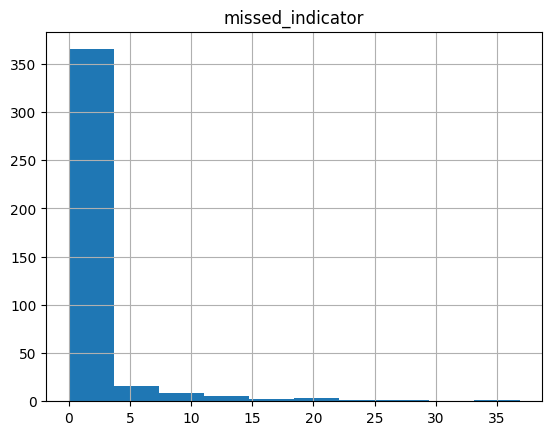

In [84]:
# Metric calculation

# Metric 1: Percentage of missed calls

# We created a missed calls indicator, taken from our sample without outliers to establish an appropriate profile of the operators

dataset_in = dataset_1[dataset_['direction'] == 'in']

missed_call = dataset_in.groupby(['operator_id', 'is_missed_call'])['calls_count'].sum()
missed_call = missed_call.reset_index()

missed_call_1 = missed_call.pivot_table(index = 'operator_id', columns = 'is_missed_call', values = 'calls_count')
missed_call_1 = missed_call_1.reset_index()
missed_call_1 = missed_call_1.fillna(0)

missed_call_1['missed_indicator'] = (missed_call_1[True]/ (missed_call_1[False] + missed_call_1[True]))*100

miss_call_list = missed_call_1.groupby('operator_id')['missed_indicator'].mean()
miss_call_list.name = 'missed_call_indicator'

miss_call_list = miss_call_list.reset_index()


missed_call_1.hist(column = 'missed_indicator')
plt.show()

# Analysis of Metric 1 Results: Missed Call Percentage

We calculated the percentage of missed calls relative to the total calls, which allowed us to establish our first metric for evaluating operators. We observed that some operators have a perfect record with 0% missed calls, while others have rates exceeding 15%. By analyzing the overall performance, we can establish a tolerance threshold of 5%, as over 350 operators out of 403 exhibit this performance.


     operator_id  avg_wait_time
0       879896.0       0.171944
1       879898.0       0.254944
2       880020.0       0.120833
3       880022.0       0.233333
4       880026.0       0.100000
..           ...            ...
398     944220.0       0.595897
399     944226.0       0.730198
400     944644.0       0.403889
401     944646.0       0.170060
402     944808.0       0.037891

[403 rows x 2 columns]
     operator_id   wait_time  calls_count  avg_time
0       879896.0   10.316667           60  0.171944
1       879898.0   30.083333          118  0.254944
2       880020.0    0.966667            8  0.120833
3       880022.0    1.866667            8  0.233333
4       880026.0    2.500000           25  0.100000
..           ...         ...          ...       ...
398     944220.0  196.050000          329  0.595897
399     944226.0  147.500000          202  0.730198
400     944644.0   12.116667           30  0.403889
401     944646.0   47.616667          280  0.170060
402     944808.0    

/tmp/ipykernel_32/778429394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_in['wait_time'] =  dataset_in['total_call_duration'] - dataset_in['call_duration']
/tmp/ipykernel_32/778429394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_in['wait_time'] = dataset_in['wait_time']/60


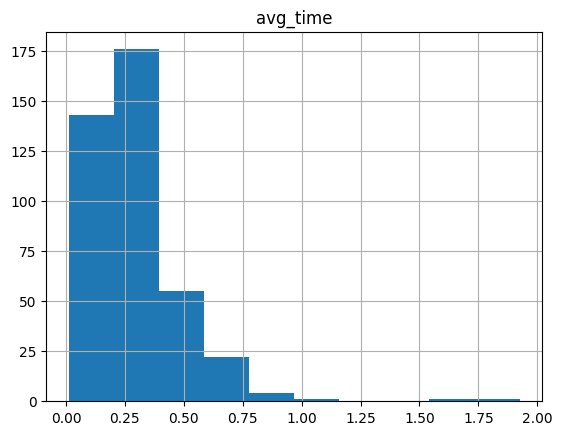

In [32]:
# Metric 2: Customer waiting time before being served

dataset_in['wait_time'] =  dataset_in['total_call_duration'] - dataset_in['call_duration']

dataset_in['wait_time'] = dataset_in['wait_time']/60

wait_time = dataset_in.groupby('operator_id')['wait_time', 'calls_count'].sum()
wait_time = wait_time.reset_index()
wait_time['avg_time'] = wait_time['wait_time']/wait_time['calls_count']

wait_time_list = wait_time.groupby('operator_id')['avg_time'].mean()
wait_time_list.name = 'avg_wait_time'
wait_time_list = wait_time_list.reset_index()
print(wait_time_list)
print(wait_time)

wait_time.hist(column ='avg_time')

plt.show()


# Analysis of Metric 2 Results: Customer Wait Time Before Being Attended

To develop this metric, we first calculated the difference between the total call duration ('total_call_duration') and the attention time ('call_duration'). This metric reflects the amount of time the customer spent waiting for the operator to answer the call. We then established an average wait time in minutes per received call.

We found that most operators take between 0 and 0.5 minutes to attend to the call, while some data points are closer to 2 minutes, indicating poor performance. Based on this, we can establish another tolerance threshold of 0.5 minutes for wait time, which equates to 30 seconds.

     operator_id  avg_out_calls
0       879896.0       8.808696
1       879898.0      66.415254
2       880020.0       0.711864
3       880022.0       1.704348
4       880026.0      21.176991
..           ...            ...
381     945298.0      44.027778
382     945302.0     196.027778
383     945312.0      69.972222
384     945316.0      76.361111
385     945322.0     139.250000

[386 rows x 2 columns]
Promedio general de llamadas al dia 18.94795750943532


/tmp/ipykernel_32/1307168799.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_out = dataset_1[(dataset_['direction'] == 'out')&(dataset_['internal'] == False)]


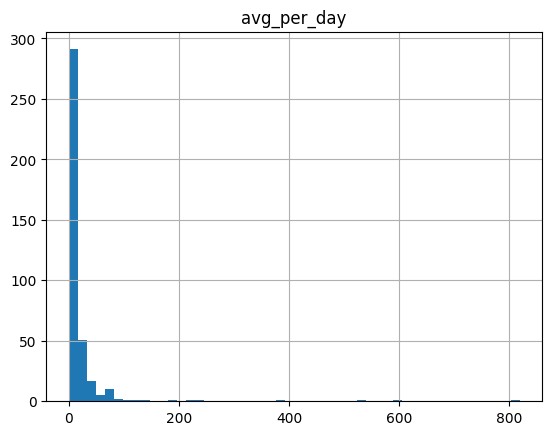

In [31]:
# Metric 3: Low number of outgoing calls

dataset_out = dataset_1[(dataset_['direction'] == 'out')&(dataset_['internal'] == False)]

out = dataset_out.groupby(['operator_id','days_operation'])['calls_count'].sum()
out = out.reset_index()
out['days_operation'] = pd.to_numeric(out['days_operation'].dt.days, downcast='integer')
out['avg_per_day'] = out['calls_count']/out['days_operation']

out_list = out.groupby('operator_id')['avg_per_day'].mean()
out_list.name = 'avg_out_calls'
out_list = out_list.reset_index()

print(out_list)

print(f'Overall average of calls per day',out['avg_per_day'].mean())
out.hist(column = 'avg_per_day', bins = 50)

plt.show()

# Analysis of Metric 3 Results: Low Number of Outgoing Calls

Outgoing calls are also an essential part of operations, and a low number of such calls reflects poor performance. We observed that most operators have a call count very close to zero, with very few operators actively trying to contact customers. This metric will require further attention in the future, as improvements might be achieved through better management. Additionally, we noticed that the total number of operators varies compared to the previous metrics, with 386 versus 402 operators, and the total values deviate from the expected values in each list. The expected total value in each list is 472.

# Conclusion of Metrics

Based on the results of the three analyses, we were able to establish the three criteria for evaluating the effectiveness of operators:

1. The missed call percentage should be below 5%.
2. The customer wait time before being attended to should be no longer than 30 seconds.
3. The minimum number of outgoing calls should be 19 per day.

# Hypothesis Development

The development of the metrics to identify ineffective operators led us to establish a hypothesis that deserves consideration.

Hypothesis: Operators with fewer days of operation show poorer performance.


In [65]:
# We will develop a list with the qualifications of the employees taken into account in the analysis, in addition to being the final report, it will help us evaluate the hypotheses raised

dataset_1['days'] = pd.to_numeric(dataset_1['days_operation'].dt.days, downcast='integer')

operator_group = dataset_1.groupby('operator_id')['days'].mean()

operator_group = operator_group.reset_index()

operator_report = operator_group.merge(miss_call_list, on = 'operator_id', how = 'outer' )

operator_report_1 = operator_report.merge(wait_time_list, on = 'operator_id', how = 'outer')

operator_report_2 = operator_report_1.merge(out_list, on = 'operator_id', how = 'outer')

# # At the end of the report we find that many operators have no record of incoming calls, we cannot replace the values ​​with 0 since they would affect the general indicators, these operators will be discarded

operator_report_final = operator_report_2.dropna()

print(operator_report_final)
    

     operator_id  days  missed_call_indicator  avg_wait_time  avg_out_calls
0       879896.0   115               0.000000       0.171944       8.808696
1       879898.0   118               0.000000       0.254944      66.415254
2       880020.0    59               0.000000       0.120833       0.711864
3       880022.0   115               0.000000       0.233333       1.704348
4       880026.0   113               0.000000       0.100000      21.176991
..           ...   ...                    ...            ...            ...
453     944218.0    36               5.882353       0.611703       4.972222
454     944220.0    36               6.382979       0.595897       6.444444
455     944226.0    36              18.811881       0.730198       3.722222
456     944644.0    36               0.000000       0.403889       3.833333
457     944646.0    36               0.357143       0.170060      10.083333

[319 rows x 5 columns]


/tmp/ipykernel_32/2834403490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_1['days'] = pd.to_numeric(dataset_1['days_operation'].dt.days, downcast='integer')


In [81]:
# Hypothesis tests, to develop our hypothesis tests we calculate the median of the days of operation, so we will have two groups before and after the median

mediana = operator_report_final['days'].median()
print(f'Median = ',mediana)

# the groups will be divided before and after 59 days, we will evaluate the results of each metric according to the established standards

# Metric 1: The percentage of lost calls must be less than 5%

# comparison of operators with fewer days of work against the expected value

misscall_new = operator_report_final[operator_report_final['days'] < 60]['missed_call_indicator']
misscall_old = operator_report_final[operator_report_final['days'] > 59]['missed_call_indicator']

alpha = 0.05

varianza_test_1 = st.levene(misscall_new, misscall_old)
print(varianza_test_1)

result_1 = st.ttest_ind(misscall_new, misscall_old, equal_var = True)

print(f'Media new operators',misscall_new.mean())
print(f'Media old operators',misscall_old.mean())
print('Valor p:', result_1.pvalue)
if (result_1.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis")


Mediana =  59.0
LeveneResult(statistic=0.030612175235608875, pvalue=0.8612201252997171)
Media operadores nuevos 1.4089544364594289
Media operadores antiguos 1.3340008862294452
Valor p: 0.86122012529974
No podemos rechazar la hipótesis nula


In [82]:
# Metric 2: The customer's waiting time before being served must be 30 seconds
# the new variables refer to operators with fewer working days

avg_wait_new = operator_report_final[operator_report_final['days'] < 60]['avg_wait_time']
avg_wait_old = operator_report_final[operator_report_final['days'] > 59]['avg_wait_time']
alpha = 0.05

varianza_test_2 = st.levene(avg_wait_new, avg_wait_old)

print(varianza_test_2)


result_2 = st.ttest_ind(avg_wait_new, avg_wait_old, equal_var = True)

print(f'Media new operators',avg_wait_new.mean())
print(f'Media old operators',avg_wait_old.mean())

print('Valor p:', result_2.pvalue)
if (result_2.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis")

LeveneResult(statistic=0.41994249683664736, pvalue=0.5174348229006707)
Media operadores nuevos 0.25217029859396156
Media operadores antiguos 0.29935859432952094
Valor p: 0.033889151361072234
Rechazamos la hipótesis nula


In [83]:
# Metric 3: The minimum number of outgoing calls must be 19 per day.

avg_out_calls_new = operator_report_final[operator_report_final['days'] < 60]['avg_out_calls']
avg_out_calls_old =operator_report_final[operator_report_final['days'] > 59]['avg_out_calls']
alpha = 0.05

varianza_test_3 = st.levene(avg_out_calls_new, avg_out_calls_old)

print(varianza_test_3)


result_3 = st.ttest_ind(avg_out_calls_new, avg_out_calls_old, equal_var = True)

print(f'Media new operators',avg_out_calls_new.mean())
print(f'Media old operators',avg_out_calls_old.mean())

print('Valor p:', result_3.pvalue)
if (result_3.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis")

LeveneResult(statistic=1.5700780161380372, pvalue=0.2111191545898321)
Media operadores nuevos 9.481658137545281
Media operadores antiguos 17.489037881209505
Valor p: 0.2156435826974055
No podemos rechazar la hipótesis nula


# Conclusion of Hypothesis Tests

During the metric calculations, we noticed certain differences in behavior between older and newer operators. We wanted to test whether the results truly vary between the two groups. We established a median of 59 days of operation to divide the new operators from the experienced ones, then compared both samples to evaluate the results.

Metric 1: Although the average values are similar (1.4 and 1.3), the hypothesis test shows that the behaviors are quite different. While the results appear favorable for both groups—since both are below the 5% missed call threshold—the outcome is optimal for both.

Metric 2: Here, we observe that the results are indeed similar, with averages of 0.25 and 0.29, and the hypothesis test suggests we reject the hypothesis. The results are highly favorable for both groups, with an average wait time below the expected 0.05 minutes.

Metric 3: The hypothesis test for this metric yields results similar to those of Metric 1, but the averages differ significantly: 9.4 for new operators and 17.4 for experienced operators. We observe poor performance from new operators, falling short of the expected 19 outgoing calls per day. However, experienced operators also fall below the expected result.

# Results Delivery

1. We have developed a report listing the performance of the operators, titled: operator_report_final. This report includes the operator code, their    days of operation, and the results of the three established metrics.
2. We implemented three metrics that will now allow for a proper evaluation of the operators:
Metric 1: The missed call percentage should be below 5%.
Metric 2: The customer wait time before being attended should be no longer than 30 seconds (0.05 minutes).
Metric 3: The minimum number of outgoing calls should be 19 per day.

Note: The established standards are the result of the previous analyses and interpretations.

3. As expected in any company, operators with fewer days of experience show poorer results compared to those with more experience.
4. Employees who have worked less than 35 days do not provide concrete performance results, so it's advisable to allow them some time for adaptation before including them in the evaluation process.

# Suggestions

1. The metrics can be improved over time and should be complemented with customer satisfaction surveys. In Metric 2, new operators showed good results, but we don't know if the customer received the expected level of service. It's not just about answering the phone quickly and attending all the calls; customer experience is key.
2. The company could establish a performance category system as follows:

Effective Operator: Meets all three metrics.
Competent Operator: Meets two of the three metrics.
Ineffective Operator: Meets only one or none of the metrics

3. These metrics represent the beginning of the evaluation process, but the operator rating system can be expanded. We should incorporate customer feedback indicators into the formulas, along with internal ratings that can provide a more comprehensive view of operator performance.